In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import os

from _stop_words import ENGLISH_STOP_WORDS

%matplotlib inline

In [2]:
directory = 'outputs/bert/'
dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Merge the DataFrames into a single DataFrame (concatenate in this case)
merged_df = pd.concat(dataframes, ignore_index=True)
pd.set_option('display.max_colwidth', None)

def literal_eval_column(column):
    try:
        return ast.literal_eval(column)
    except (SyntaxError, ValueError):
        return column

merged_df = merged_df.applymap(literal_eval_column)

In [14]:
gold = pd.read_csv('outputs/20newsgroups_test.csv', encoding='utf-8')

def compare_pred(row):
    return 1 if row['label_pred'] == gold['label_text'][row.index] else 0

merged_df['label_gold'] = gold['label_text']
merged_df['correct'] = merged_df.label_gold == merged_df.label_pred
merged_df['sum_attributions'] = merged_df['attributions'].apply(lambda x: sum(x) if isinstance(x, list) else None)

In [15]:
filtered = merged_df.dropna(subset='tokens')
len(filtered)

455

In [17]:
min(filtered.sum_attributions), max(filtered.sum_attributions)

(-1.0986565373830173, 8.962276127000221)

In [21]:
# corrcoeff (Pearson) = 0.25 -> weak or no correl
np.correlate(filtered.score, filtered.sum_attributions), np.corrcoef(filtered.score, filtered.sum_attributions)

(array([649.79005612]),
 array([[1.        , 0.25077146],
        [0.25077146, 1.        ]]))

In [22]:
np.corrcoef(filtered.score, filtered.tokens.apply(len))

array([[1.        , 0.24366537],
       [0.24366537, 1.        ]])

In [16]:
filtered

Unnamed: 0              label_pred     score  \
0             0               rec.autos  0.875687   
1             0          comp.windows.x  0.878905   
2             1   talk.politics.mideast  0.104483   
7             6             alt.atheism  0.577951   
12           11             alt.atheism  0.385768   
..          ...                     ...       ...   
630         629           comp.graphics  0.278577   
631         630                 sci.med  0.794507   
632         631             alt.atheism  0.533052   
633         632  soc.religion.christian  0.748695   
634         633         rec.motorcycles  0.853590   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             tokens  \
0                                           [i, am, a, little, confused, on, all, of, the, models, of, the, 88, -, 89, bonn, ##eville, ##s, ., i, have, heard, of, the, le, se, l, ##se, ss, ##e, ss, ##ei, ., could, someone, tell, me, the, differences, are, far, as, features, or, performance, ., i, am, also, curious, to, know, what, the, book, value, is, for, prefer, ##ea, ##bly, the, 89, model, ., and, how, much, less, than, book, value, can, you, usually, get, them, for, ., in, other, words, how, much, are, they, in, demand, this, time, of, year, ., i, have, heard, that, the, mid, -, ...]   
1                                                                                                                     [i, ', m, not, familiar, at, all, with, the, format, of, these, ", x, -, face, :, ", thing, ##ies, ,, but, after, seeing, them, in, some, folks, ', header, ##s, ,, i, ', ve, *, got, *, to, *, see, *, them, (, and, maybe, make, one, of, my, own, ), !, i, ', ve, got, ", d, ##pg, -, view, ", on, my, linux, box, (, which, displays, ", un, ##com, ##pressed, x, -, faces, ", ), and, i, ', ve, managed, to, com, ##pile, [, un, ], com, ##pf, ##ace, too, ., ., ., but, now, that, ...]   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [in, a, word, ,, yes, .]   
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [i, ', ve, just, spent, two, solid, months, arguing, that, no, such, thing, as, an, objective, moral, system, exists, .]   
12                                                                                                                                                                                                                                                                                                                                                                                   

In [9]:
def plot_instance(row, output=''):
    a = pd.Series(row['attributions'].tolist()[0], row['tokens'].tolist()[0])
    a.plot.barh(figsize=(10,20))
    if output:
         plt.savefig(f'{output}/{str(row.index[0])}.png', bbox_inches='tight')

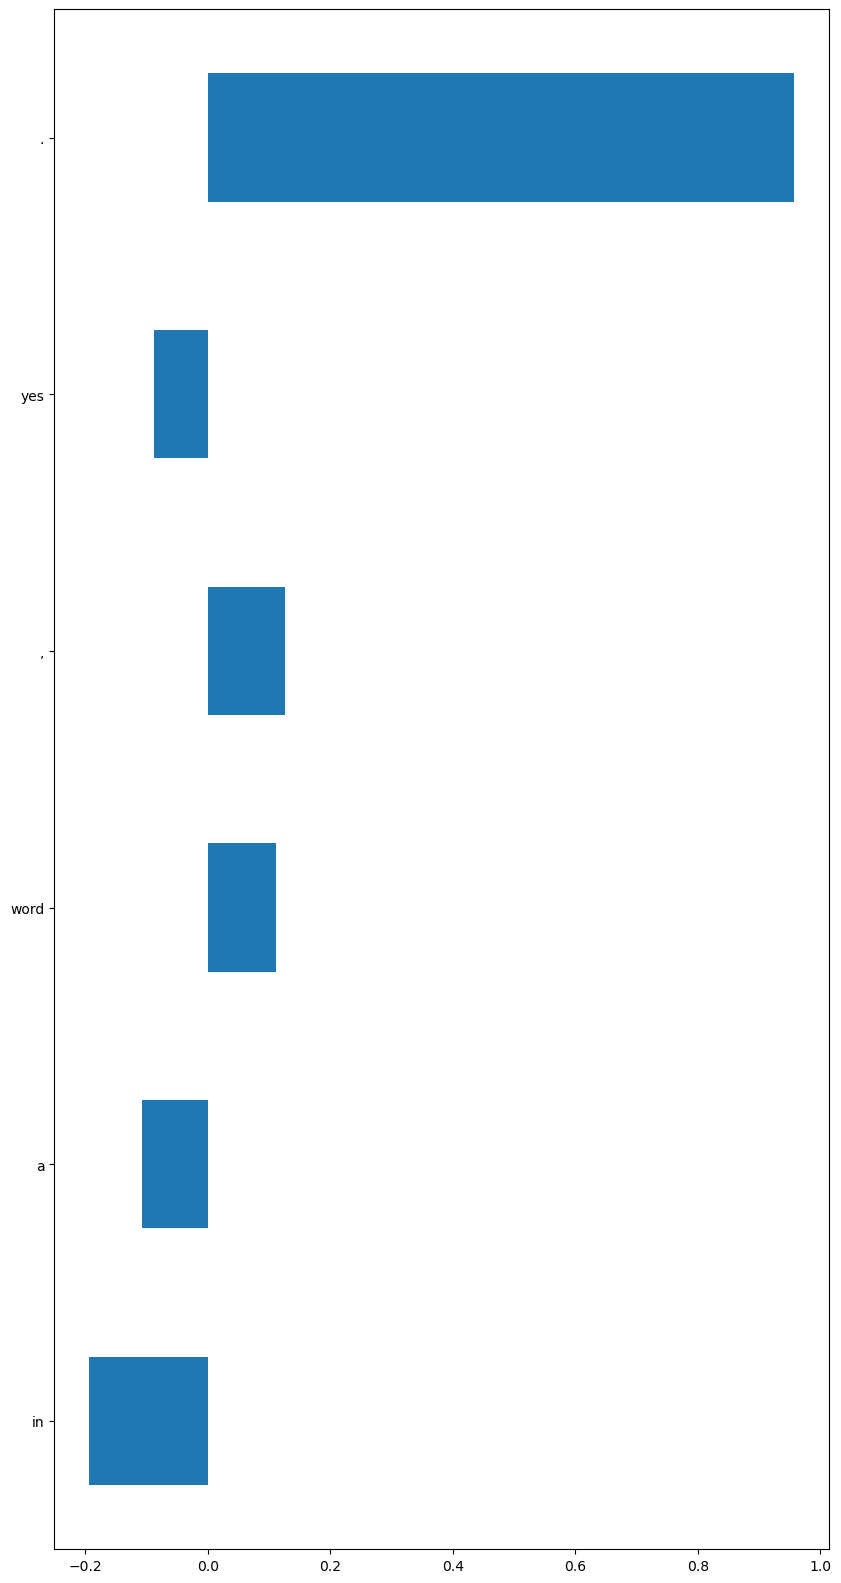

In [11]:
plot_instance(merged_df.iloc[[2]], output='outputs/viz-bert')

In [7]:
labels = [
    "alt.atheism",
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc"
]

In [35]:
vocab_attributions = dict()
vocab_attributions_by_class = {label: dict() for label in labels}
ignore_stopwords = False
merge_subwords = True
aggregate = 'mean'

def dict_entries(token, attribution, by_class=True):
    if token in vocab_attributions:
            vocab_attributions[token].append(attribution)
    else:
        vocab_attributions[token] = [attribution]
    if by_class:
        if token in vocab_attributions_by_class[label]:
            vocab_attributions_by_class[label][token].append(attribution)
        else:
            vocab_attributions_by_class[label][token] = [attribution]


for k, row in merged_df.iterrows():
    if type(row['tokens']) == float:
        continue
    assert len(row['attributions']) == len(row['tokens'])
    label = row['label_gold']
    # skip merged tokens
    skip_next_iteration = 0
    # iterate over tokens to save attributions
    for i, token in enumerate(row['tokens']):
        if skip_next_iteration != 0:
            skip_next_iteration -= 1
            continue
        word = token
        attribution = row['attributions'][i]
        # detokenize
        if merge_subwords:
            # check whether next token starts with ##
            if i < len(row['tokens'])-1 and row['tokens'][i+1].startswith('##'):
                # check whether further tokens start with ##
                to_merge = row['tokens'][i:]
                count = 1
                iterator = iter(to_merge[1:])
                while True:
                    try:
                        token = next(iterator)
                        if token.startswith("##"):
                            count += 1
                        else:
                            break
                    except StopIteration:
                        break
                to_merge = to_merge[:count]
                j = len(to_merge)
                word = ''.join(row['tokens'][i:i+j]).replace('##', '')
                attr = [row['attributions'][i:i+j]]
                if aggregate == 'mean':
                    attribution = np.mean(attr)
                skip_next_iteration = count-1
        # skip stop words
        if ignore_stopwords:
            if word in ENGLISH_STOP_WORDS:
                continue
        # create or update dict entries with attributions
        dict_entries(word, attribution)
    # check on 1 instance only to start with
    #break


if ignore_stopwords:
    assert set(vocab_attributions.keys()).intersection(ENGLISH_STOP_WORDS) == {}


In [36]:
vocab_attributions

{'i': [-0.08908338556650067,
  -0.02692663030270621,
  -0.0324786870053675,
  -0.021296673957289448,
  -0.16000796394638991,
  0.00852820936723035,
  0.006558687599048833,
  0.009369352093735125,
  0.017404933047803255,
  0.004599522889856492,
  0.0007522995841805983,
  0.003063008165501114,
  -0.00515047528339087,
  -0.07778557940796625,
  -0.15498732217607042,
  0.01583359398487167,
  0.01853180387823048,
  0.04790490753184762,
  0.021601178742469754,
  0.016371216850831902,
  0.01240536319546673,
  0.013310734848719858,
  0.16996148321617693,
  0.02499708872852453,
  0.16411246956307202,
  -0.00877745300946777,
  0.01790528479776149,
  -0.007482031714433979,
  -0.0002860420413916122,
  -0.01765390222481129,
  -0.021583591585924516,
  0.029697195893825877,
  0.04626973524773475,
  0.02197163189217205,
  0.020563548060199877,
  0.0471750251601826,
  -0.02541325440925168,
  0.014294872001612837,
  0.023108969615091113,
  0.00012002182549728798,
  -0.19351771513393998,
  0.0180162586406

In [37]:
vocab_attributions_by_class

{'alt.atheism': {'in': [-0.19382938156955007,
   0.037745199185423794,
   0.03348229484877157,
   -0.0069002932884402925,
   0.005088587792657234,
   -0.01766677445111239,
   0.010027899801640284,
   -0.0017788840982321005,
   -0.005096426297986955,
   0.00788898830926347,
   -0.007329852162658207,
   -0.005368477216538616,
   0.05799464041065173,
   -0.013754701483842939,
   0.025821155130160634,
   0.022274810475093512,
   0.03301198982957887,
   0.003408437863668047,
   0.0035403664781250223,
   0.046443783264201274,
   0.01222256074105702,
   0.004690995071816764,
   0.020401640041024113,
   -0.0002173548859186238,
   0.05902917580495643,
   0.06345116272584787,
   -0.037077758292107334,
   0.06297322432691717,
   0.09994817868886631,
   0.004406283375716583,
   0.007622460221867813,
   0.003795749052586507,
   -0.0014702520918067684,
   0.0158466459645588,
   0.010819240601781691,
   0.000620741145010521,
   0.004447132516821423,
   -0.0009460613398302691,
   -0.004971333367652246

In [43]:
average_attr_by_class = {
    label: {
        token: np.mean([a for a in attr if isinstance(a, float)])
        for token, attr in labeldict.items()
    }
    for label, labeldict in vocab_attributions_by_class.items()
}

average_attr_by_class

{'alt.atheism': {'in': 0.00924604597749712,
  'a': 0.011409368041400329,
  'word': 0.11109851499471249,
  ',': 0.010167533977625877,
  'yes': -0.03394669717646616,
  '.': -0.007982151332210892,
  'hi': -0.015468013355502557,
  'we': 0.0115360577385267,
  'have': 0.006708550806391167,
  'requirement': 0.01268492049817585,
  'for': 0.02070674060411142,
  'dynamically': 0.04988410177302224,
  'closing': -0.00017147137828781194,
  'and': 0.003714074932790504,
  'opening': 0.05063924608876264,
  'different': 0.14541635151292986,
  'display': 0.2619392232808387,
  'servers': 0.2796909906333416,
  'within': 0.10902639396773042,
  'an': 0.02115334455543617,
  'x': 0.5633542738390199,
  'application': 0.4389174836669797,
  'manner': 0.03426655262777632,
  'such': 0.008688528623242982,
  'that': -0.015692063163911696,
  'at': 0.0005516460417785813,
  'any': 0.0278558152034938,
  'time': 0.04369604051309793,
  'there': 0.008802781742809844,
  'is': 0.0059919696726026435,
  'only': 0.0074374817617

In [44]:
average_attr_by_class["comp.os.ms-windows.misc"]

{':': -0.012197173505559591,
 'well': -0.004012757572673479,
 ',': 0.006786301925739304,
 'i': 0.009904411585145392,
 'have': 0.006157014164209057,
 'lots': -0.0017651370133048366,
 'of': 0.011415650227056064,
 'experience': 0.04151100549903223,
 'with': 0.018561280022174,
 'scanning': 0.1352595867213774,
 'in': 0.018942584187707587,
 'images': 0.6619949373560415,
 'and': -2.155156960003232e-05,
 'altering': -0.010360532578916766,
 'them': 0.0946018751522242,
 '.': -0.005679857010107251,
 'as': 0.00917820427958884,
 'for': 0.0021066781617148055,
 'changing': 0.0059420035224485215,
 'back': 0.012587335467778344,
 'into': 0.002491190048608766,
 'negatives': 0.0039711551306960404,
 'is': 0.0008897934114321978,
 'that': -0.010825355201433911,
 'really': -0.007043280639388618,
 'possible': 0.02908208242185548,
 '?': 0.012402633803159924,
 '(': -0.01569123942495135,
 'stuff': -0.000524511095449653,
 'deleted': -0.019137216374140068,
 ')': -0.01266186121496572,
 'jennifer': -0.020801268218446

In [45]:
def sort_attr_dict(attr_dict):
    return dict(sorted(attr_dict.items(), key=lambda item: item[1], reverse=True))

In [46]:
sort_attr_dict(average_attr_by_class["comp.os.ms-windows.misc"])

{'lane': 0.9530150646091423,
 'rental': 0.7456156121469731,
 'images': 0.6619949373560415,
 'revenue': 0.5399374938498219,
 'bike': 0.5363666705950517,
 'graphics': 0.5076216306066832,
 'vans': 0.48881443082094345,
 'shuttle': 0.4824386611525553,
 'house': 0.4763295947722416,
 'clinton': 0.4492781980099584,
 'jersey': 0.43391721226995167,
 'orbit': 0.4093001095739214,
 'church': 0.4060112496863071,
 'glassboro': 0.3846658546014436,
 'apple': 0.37839684944925017,
 'administration': 0.3759246331105996,
 'jacket': 0.3634104337080142,
 'bit': 0.3434744424026125,
 'corona': 0.32562098008941387,
 'incestuous': 0.32200972418329904,
 'selling': 0.3198741146514109,
 'wrestling': 0.30374656468810135,
 'ram': 0.2783038881805385,
 'ford': 0.27696400249875286,
 'sauce': 0.2520061479950303,
 'recording': 0.2479260118133652,
 'owner': 0.23335584568574344,
 'design': 0.2278841513108362,
 'photographs': 0.22549645793903833,
 'video': 0.22153338815903126,
 'engines': 0.22092499975882582,
 'user': 0.2208

In [50]:
len(set(average_attr_by_class["comp.os.ms-windows.misc"].keys()).intersection(set(average_attr_by_class["alt.atheism"].keys()))), \
len(set(average_attr_by_class["comp.os.ms-windows.misc"].keys()).difference(set(average_attr_by_class["alt.atheism"].keys())))

(272, 767)

In [51]:
len(set(average_attr_by_class["rec.motorcycles"].keys()).intersection(set(average_attr_by_class["alt.atheism"].keys()))), \
len(set(average_attr_by_class["rec.motorcycles"].keys()).difference(set(average_attr_by_class["alt.atheism"].keys())))

(298, 975)

In [47]:
sort_attr_dict(average_attr_by_class["alt.atheism"])

{'bike': 0.8911251722063773,
 'car': 0.8105155744159704,
 'les': 0.7930193629409442,
 'circuit': 0.7114029099281768,
 'christianity': 0.6998509426737692,
 'israel': 0.6884785073300536,
 'drivers': 0.6535426523518252,
 'instruments': 0.5800119106585804,
 'x': 0.5633542738390199,
 'quantum': 0.5495267951386072,
 'engine': 0.5223070594080544,
 'transmission': 0.5023366632212773,
 'cars': 0.47961747936822413,
 'racing': 0.47732088396811745,
 'application': 0.4389174836669797,
 'disease': 0.4102923169029936,
 'god': 0.39674033527698643,
 'street': 0.3928693925636561,
 '286': 0.38096480485364764,
 'cup': 0.3750036258302804,
 'data': 0.35492560153478475,
 'israeli': 0.3458414319004114,
 'equipment': 0.33515366847707745,
 'card': 0.31859301987514665,
 'teams': 0.31755549881365985,
 'bikes': 0.293403213099152,
 'speed': 0.2898148136538362,
 'hard': 0.28538269835521785,
 'servers': 0.2796909906333416,
 'shaft': 0.27693611161040105,
 'display': 0.2619392232808387,
 'faith': 0.26099748915913756,
 